# Build Collaborative Filtering Models

## Collaborative Filtering
In collaborative filtering, the model learns from the user's past behavior (in this case, their past book ratings) and incorporates other users with similar behavior.

## Models
This script builds the following collaborative filtering models:
- **NormalPredictor:** Predict a random rating based on the distribution of the training set, which is assumed to be normal (**Note:** the training set is **not** normally distributed)
- **BaselineOnly:** Predict the *baseline* estimate for a given user and item
- **KNN:** *k*-Nearest Neighbors based on *similarity*
    - **KNNBasic:** 
    - **KNNWithMeans:** Take into account the mean ratings of each user
    - **KNNBaseline:** Take into account a *baseline* rating
- **MatrixFactorization:** Discover latent features underlying the interactions between users and items
    - **SVD:** Use gradient descent to minimize the squared error between the predicted and actual rating.
    - **NMF:** Non-negative matrix factorization
- **SlopeOne:** 
- **CoClustering:** 

Similarity metrics:
- **Cosine:** Cosine similarity
- **MSD:** Mean Squared Difference similarity
- **Pearson:** Pearson correlation coefficient
- **PearsonBaseline:** (Shrunk) Pearson correlation coefficient

## Performance
All of these models are built in order to assess which one yields the best performance. Several performance metrics were measured:
- **RMSE:** Root Mean Squared Error
- **MSE:** Mean Squared Error
- **MAE:** Mean Absolute Error
- **FCP:** Fraction of Concordant Pairs

In [0]:
!pip install -q pydrive
!pip install -q surprise

In [0]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import joblib, surprise
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Mount Google Drive

In [203]:
# mount Google drive
from google.colab import drive
drive.mount('/content/drive/')

# authenticate and create the PyDrive clident
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


# Load Datasets

In [0]:
num_reviews = 1E4

# load training data
train_name = 'trainingReviews_' + str(int(num_reviews)) + '.joblib'
train_path = F'/content/drive/My Drive/Insight/Colab_Data/{train_name}'
reviews = joblib.load(train_path)

# Train Models

In [0]:
def cv(data, kf, model, bsl_options=None, sim_options=None):
  """

  INPUTS:
  data: (dataset)
  kf: cross-validation iterator
  model: 
  bsl_options: 
  sim_options: 
  OUTPUT
  benchmark: (DataFrame)
  """
  col_names = ['RMSE', 'MSE', 'MAE', 'FCP']
  benchmark = pd.DataFrame(columns=col_names)
  
  for trainSet, testSet in kf.split(data):
    if bsl_options is not None:
      model.bsl_options = bsl_options
    if sim_options is not None:
      model.sim_options = sim_options
    
    # train model
    model.fit(trainSet)
    # test model
    predictions = model.test(testSet)
    # computer performance
    rmse = surprise.accuracy.rmse(predictions, verbose=False)
    mse = surprise.accuracy.mse(predictions, verbose=False)
    mae = surprise.accuracy.mae(predictions, verbose=False)
    fcp = surprise.accuracy.fcp(predictions, verbose=False)
    # add to dataframe
    tmp = pd.Series([rmse, mse, mae, fcp])
    tmp.index = col_names
    benchmark = benchmark.append(tmp, ignore_index=True)
  return benchmark

In [0]:
col_names = ['RMSE', 'MSE', 'MAE', 'FCP', 'Model']
benchmark_df = pd.DataFrame(columns=col_names)

# define a cross-validation iterator
kf = surprise.model_selection.KFold(n_splits=5)

## Normal Predictor

In [207]:
# NormalPredictor
algo_list = [surprise.NormalPredictor()]
# iterate over all algorithms
for algorithm in algo_list:
  modelName = str(algorithm).split('surprise.')[1].split(' ')[0].split('.')[-1].replace("'>","")
  print(modelName)

  # perform cross validation
  results = cv(reviews, kf, algorithm)
  # put summary of results into dataframe
  tmp_df = pd.DataFrame.from_dict(results).mean(axis=0)
  tmp_df = tmp_df.append(pd.Series(modelName))
  tmp_df.index = col_names
  benchmark_df = benchmark_df.append(tmp_df, ignore_index=True)

  print('...done!\n')

NormalPredictor
...done!



## Baseline Only

In [208]:
# BaselineOnly
# baseline configuration
bsl_options = {'method': ['als', 'sgd']} # Alternating Least Squares and Stochastic Gradient Descent
algo_list = [surprise.BaselineOnly()]
# iterate over all algorithms
for algorithm in algo_list:
  modelName = str(algorithm).split('surprise.')[1].split(' ')[0].split('.')[-1].replace("'>","")
  print(modelName)

  # perform cross validation
  for bsl_method in bsl_options['method']:
    params = {'method': bsl_method}
    results = cv(reviews, kf, algorithm, bsl_options=params)
    # put summary of results into dataframe
    tmp_df = pd.DataFrame.from_dict(results).mean(axis=0)
    tmp_df = tmp_df.append(pd.Series(modelName + '_' + bsl_method))
    tmp_df.index = col_names
    benchmark_df = benchmark_df.append(tmp_df, ignore_index=True)

  print('...done!\n')

BaselineOnly
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
...done!



## *k*-NN Inspired Algorithms

### Similarity Only

In [209]:
# k-NN Inpsired Algorithms
# similarity configuration
sim_options = {}
sim_options['name'] = ['cosine', 'msd']
sim_options['user_based'] = ['True', 'False']
sim_options['min_support'] = [5, 10, 25]
algo_list = [surprise.KNNBasic(), surprise.KNNWithMeans()]
params = {'name': 'cosine',
          'user_based': True,
          'min_support': 1}
# iterate over all algorithms
for algorithm in algo_list:
  modelName = str(algorithm).split('surprise.')[1].split(' ')[0].split('.')[-1].replace("'>","")
  print(modelName)

  # perform cross validation
  for sim_name in sim_options['name']:
    params['name'] = sim_name
    for sim_user_based in sim_options['user_based']:
      params['user_based'] = sim_user_based
      for sim_min_support in sim_options['min_support']:
        params['min_support'] = sim_min_support
        results = cv(reviews, kf, algorithm, sim_options=params)
        # put summary of results into dataframe
        tmp_df = pd.DataFrame.from_dict(results).mean(axis=0)
        tmp_df = tmp_df.append(pd.Series(modelName + '_' + sim_name + '_' + sim_user_based + '_' + str(sim_min_support)))
        tmp_df.index = col_names
        benchmark_df = benchmark_df.append(tmp_df, ignore_index=True)

  print('...done!\n')

KNNBasic
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Com

### Baseline

In [210]:
# k-NN Inpsired Algorithms
# baseline configuration
bsl_options = {'method': ['als', 'sgd']} # Alternating Least Squares and Stochastic Gradient Descent
# similarity configuration
sim_options = {}
sim_options['name'] = ['cosine', 'msd']
sim_options['user_based'] = ['True', 'False']
sim_options['min_support'] = [5, 10, 25]
algo_list = [surprise.KNNBaseline()]
params = {'name': 'cosine',
          'user_based': True,
          'min_support': 1}
# iterate over all algorithms
for algorithm in algo_list:
  modelName = str(algorithm).split('surprise.')[1].split(' ')[0].split('.')[-1].replace("'>","")
  print(modelName)

  # perform cross validation
  for bsl_method in bsl_options['method']:
    bsl_params = {'method': bsl_method}
    for sim_name in sim_options['name']:
      params['name'] = sim_name
      for sim_user_based in sim_options['user_based']:
        params['user_based'] = sim_user_based
        for sim_min_support in sim_options['min_support']:
          params['min_support'] = sim_min_support
          results = cv(reviews, kf, algorithm, bsl_options=bsl_params, sim_options=params)
          # put summary of results into dataframe
          tmp_df = pd.DataFrame.from_dict(results).mean(axis=0)
          tmp_df = tmp_df.append(pd.Series(modelName + '_' + bsl_method + '_' + sim_name + '_' + sim_user_based + '_' + str(sim_min_support)))
          tmp_df.index = col_names
          benchmark_df = benchmark_df.append(tmp_df, ignore_index=True)

  print('...done!\n')

KNNBaseline
Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using a

## Matrix Factorization

In [211]:
# Matrix Factorization
algo_list = [surprise.SVD(), surprise.SVDpp(), surprise.NMF()]
# iterate over all algorithms
for algorithm in algo_list:
  modelName = str(algorithm).split('surprise.')[1].split(' ')[0].split('.')[-1].replace("'>","")
  print(modelName)

  # perform cross validation
  results = cv(reviews, kf, algorithm)
  # put summary of results into dataframe
  tmp_df = pd.DataFrame.from_dict(results).mean(axis=0)
  tmp_df = tmp_df.append(pd.Series(modelName))
  tmp_df.index = col_names
  benchmark_df = benchmark_df.append(tmp_df, ignore_index=True)

  print('...done!\n')

SVD
...done!

SVDpp
...done!

NMF
...done!



## SlopeOne and CoClustering

In [212]:
# Other
algo_list = [surprise.SlopeOne(), surprise.CoClustering()]
# iterate over all algorithms
for algorithm in algo_list:
  modelName = str(algorithm).split('surprise.')[1].split(' ')[0].split('.')[-1].replace("'>","")
  print(modelName)

  # perform cross validation
  results = cv(reviews, kf, algorithm)
  # put summary of results into dataframe
  tmp_df = pd.DataFrame.from_dict(results).mean(axis=0)
  tmp_df = tmp_df.append(pd.Series(modelName))
  tmp_df.index = col_names
  benchmark_df = benchmark_df.append(tmp_df, ignore_index=True)

  print('...done!\n')

SlopeOne
...done!

CoClustering
...done!



# Save

In [213]:
file_name = 'CFbenchmark_' + str(int(num_reviews)) + '.joblib'
file_path = F'/content/drive/My Drive/Insight/Colab_Data/{file_name}'
joblib.dump(benchmark_df, file_path)

['/content/drive/My Drive/Insight/Colab_Data/CFbenchmark_10000.joblib']

# Performance

In [214]:
col_names = ['Model', 'BaselineMethod', 'SimilarityMethod', 'UserBased', 'MinSupport']
model_info = pd.DataFrame(columns=col_names)

for modelName in benchmark_df['Model']:
  split_modelName = modelName.split('_')
  model = split_modelName[0]
  if len(split_modelName) == 1:
    bsl_method = None
    sim_method = None
    user_based = None
    min_support = None
  elif len(split_modelName) == 2:
    bsl_method = split_modelName[1]
    sim_method = None
    user_based = None
    min_support = None
  else:
    bsl_method = None
    sim_method = split_modelName[1]
    user_based = split_modelName[2]
    min_support = split_modelName[3]
  d_sr = pd.Series([model, bsl_method, sim_method, user_based, min_support])
  d_sr.index = col_names
  model_info = model_info.append(d_sr, ignore_index=True)

model_info.head(5)

,Model,BaselineMethod,SimilarityMethod,UserBased,MinSupport
0,NormalPredictor,None,None,None,None
1,BaselineOnly,als,None,None,None
2,BaselineOnly,sgd,None,None,None
3,KNNBasic,None,cosine,True,5
4,KNNBasic,None,cosine,True,10


In [215]:
import palettable.cartocolors as ct
import matplotlib.colors as clrs
import numpy as np

colors_rgb = [tuple(c) for c in (np.array(ct.qualitative.Vivid_10.colors)/256)]
cmap = dict(zip(model_info['Model'].unique(), colors_rgb))
colors = [cmap[model] for model in model_info['Model']]
benchmark_df['colors'] = colors
benchmark_df.head(5)

,RMSE,MSE,MAE,FCP,Model,colors
0,1.386287,1.922258,1.098637,0.504033,NormalPredictor,"(0.89453125, 0.5234375, 0.0234375)"
1,1.029212,1.059455,0.796846,0.451357,BaselineOnly_als,"(0.36328125, 0.41015625, 0.69140625)"
2,1.028269,1.057727,0.797237,0.445339,BaselineOnly_sgd,"(0.36328125, 0.41015625, 0.69140625)"
3,1.034649,1.070787,0.800868,0.000000,KNNBasic_cosine_True_5,"(0.3203125, 0.734375, 0.63671875)"
4,1.034227,1.069874,0.800611,0.000000,KNNBasic_cosine_True_10,"(0.3203125, 0.734375, 0.63671875)"


## RMSE

There is not much difference between the errors, with the exception of the Normal Predictor model, which is the worst.

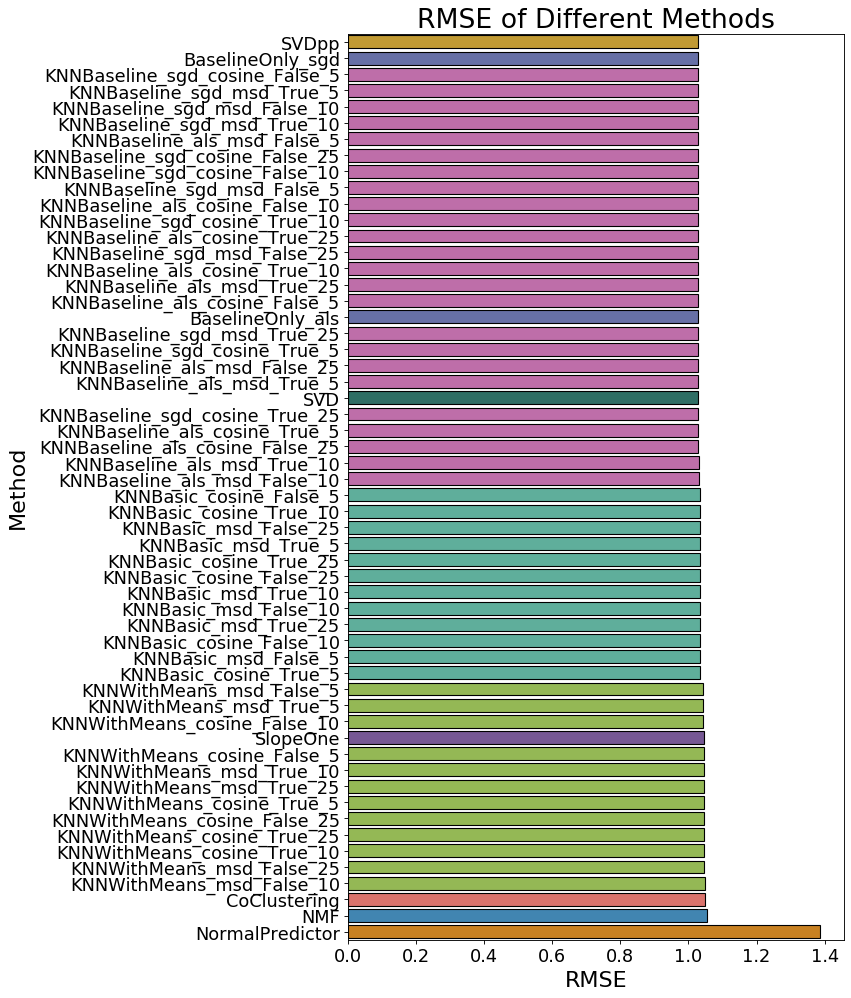

In [216]:
plt_data = benchmark_df[['Model','RMSE', 'colors']].sort_values(by='RMSE')
palette = dict(zip(plt_data['Model'], plt_data['colors']))

plt.figure(num=1, figsize=(8,15), dpi=80)
ax = sns.barplot(x='RMSE', y='Model', data=plt_data, palette=palette, edgecolor='k', linewidth=1)
plt.rc('font',size=16)
plt.xlabel('RMSE', FontSize=20)
plt.ylabel('Method', FontSize=20)
plt.title('RMSE of Different Methods', FontSize=24);

##MSE

There is not much difference between the errors, with the exception of the Normal Predictor model, which is the worst.

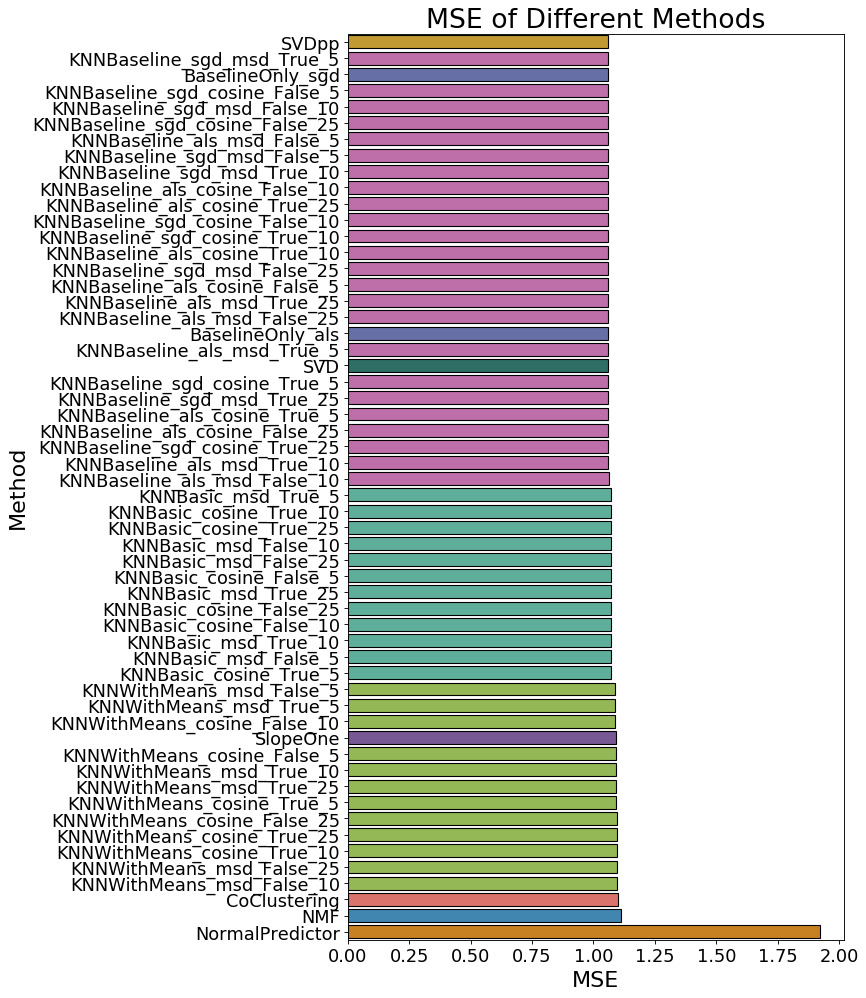

In [217]:
plt_data = benchmark_df[['Model','MSE','colors']].sort_values(by='MSE')
palette = dict(zip(plt_data['Model'], plt_data['colors']))

plt.figure(num=1, figsize=(8,15), dpi=80)
ax = sns.barplot(x='MSE', y='Model', data=plt_data, palette=palette, edgecolor='k', linewidth=1)
plt.rc('font',size=16)
plt.xlabel('MSE', FontSize=20)
plt.ylabel('Method', FontSize=20)
plt.title('MSE of Different Methods', FontSize=24);

## MAE

There is not much difference between the errors, with the exception of the Normal Predictor model, which is the worst.

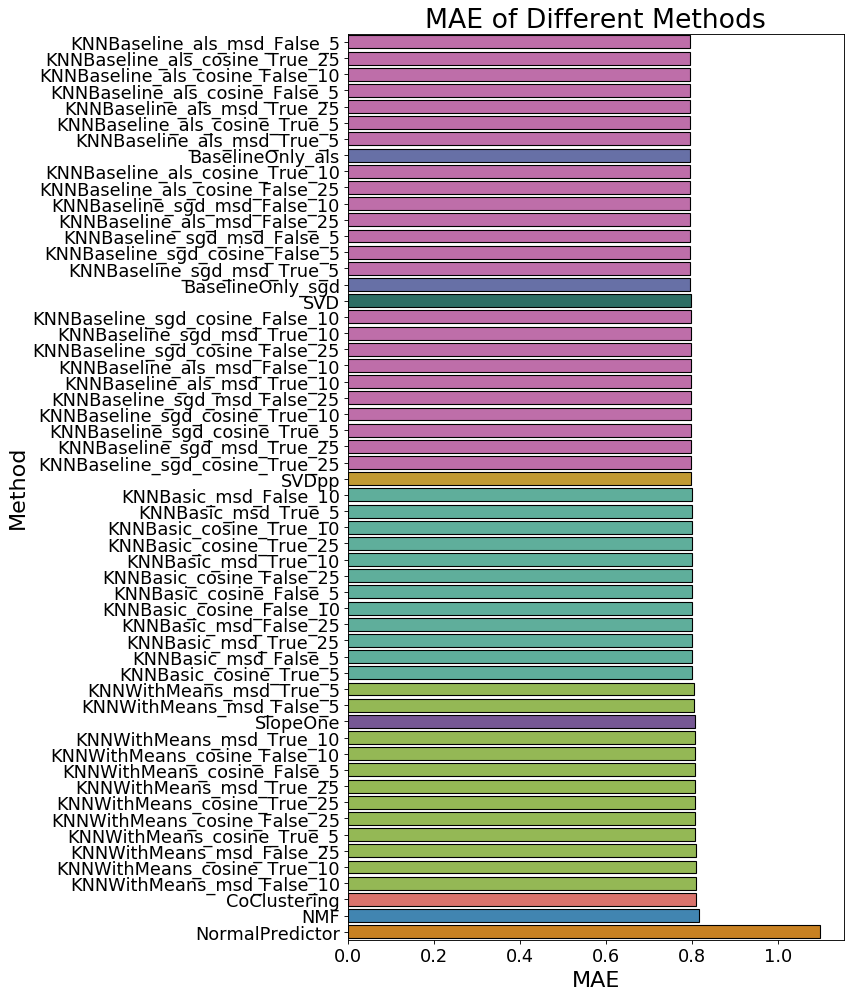

In [218]:
plt_data = benchmark_df[['Model','MAE','colors']].sort_values('MAE')
palette = dict(zip(plt_data['Model'], plt_data['colors']))

plt.figure(num=1, figsize=(8,15), dpi=80)
ax = sns.barplot(x='MAE', y='Model', data=plt_data, palette=palette, edgecolor='k', linewidth=1)
plt.rc('font',size=16)
plt.xlabel('MAE', FontSize=20)
plt.ylabel('Method', FontSize=20)
plt.title('MAE of Different Methods', FontSize=24);

## FCP

There is more difference between the errors, and the basic *k*-NN Basic method does not use the FCP error metric.

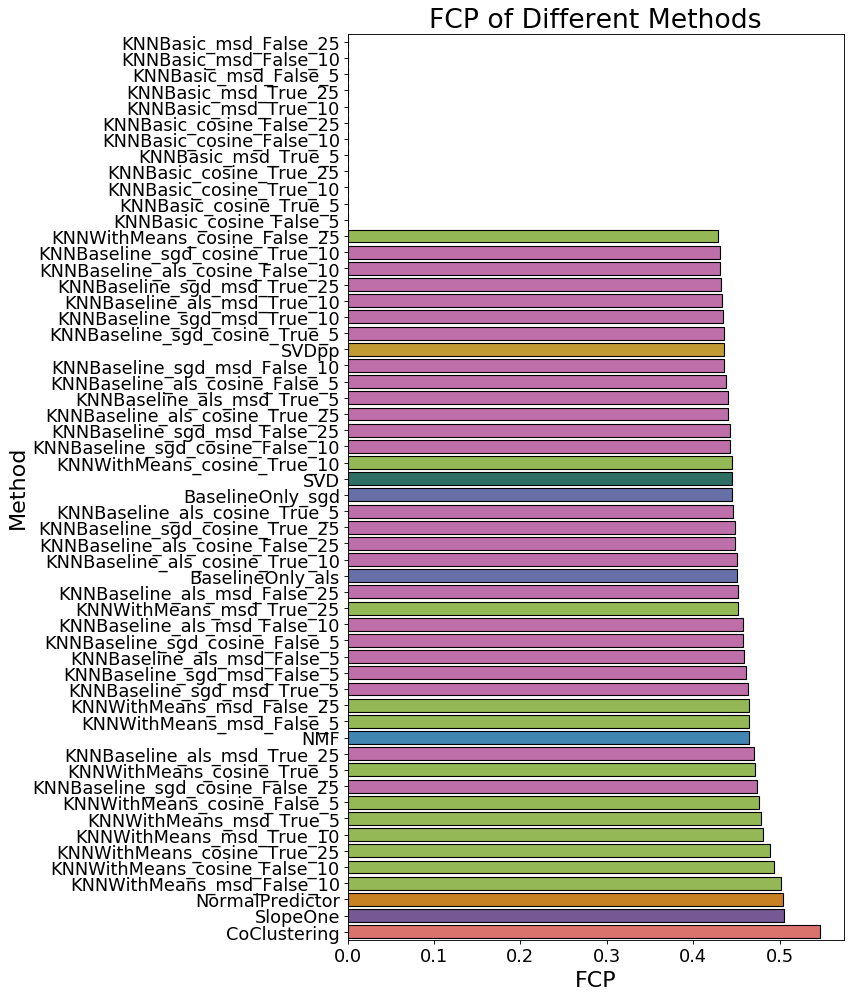

In [219]:
plt_data = benchmark_df[['Model','FCP','colors']].sort_values('FCP')
palette = dict(zip(plt_data['Model'], plt_data['colors']))

plt.figure(num=1, figsize=(8,15), dpi=80)
ax = sns.barplot(x='FCP', y='Model', data=plt_data, palette=palette, edgecolor='k', linewidth=1)
plt.rc('font',size=16)
plt.xlabel('FCP', FontSize=20)
plt.ylabel('Method', FontSize=20)
plt.title('FCP of Different Methods', FontSize=24);